In [4]:
%reload_ext autoreload
%autoreload 2

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [77]:
from utils import World, Rainfall, movmean

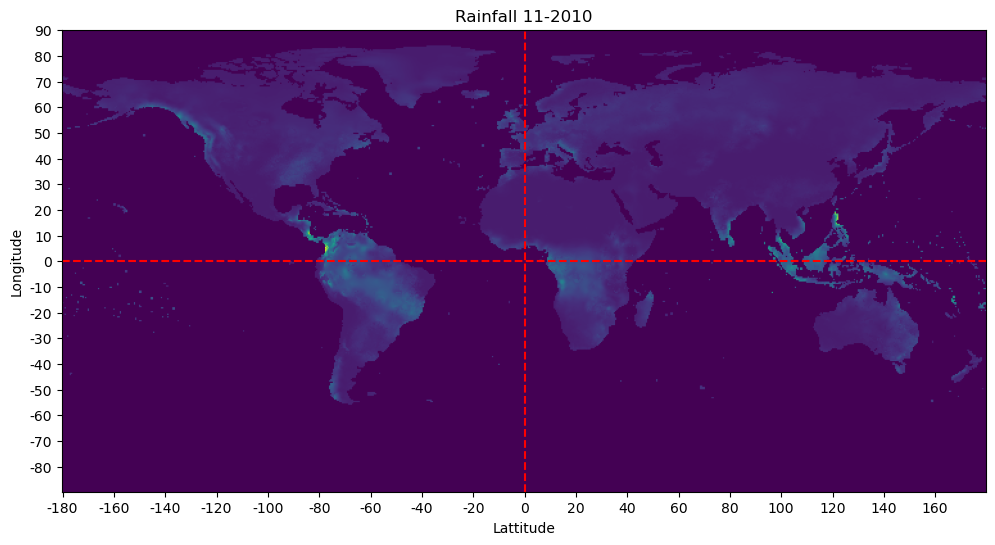

In [70]:
# fetch data
rainfall = Rainfall()
rainfall.fetch_data_years(1901, 2023, delete_file=True)

# get 2001 january for the entire world and plot
ax = rainfall.plot_month(11, 2010)
plt.show()

In [43]:
# create the world object
world = World('tests/aux_files/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp')
world.create_lookup()

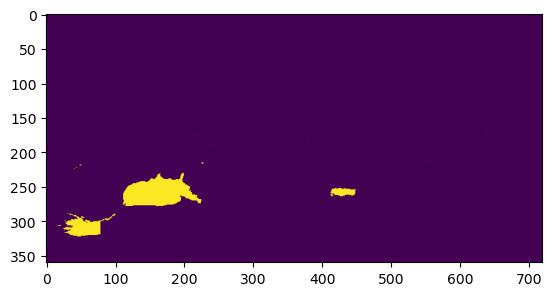

In [47]:
# quick test for selecting country
idx = world.get_grid_points_of_country(iso_code='TUR')
data = np.copy(rainfall.get_month(5, 2007))
data[idx] = 999999
idx = world.get_grid_points_of_country(iso_code='US1')
data[idx] = 999999
plt.imshow(data)

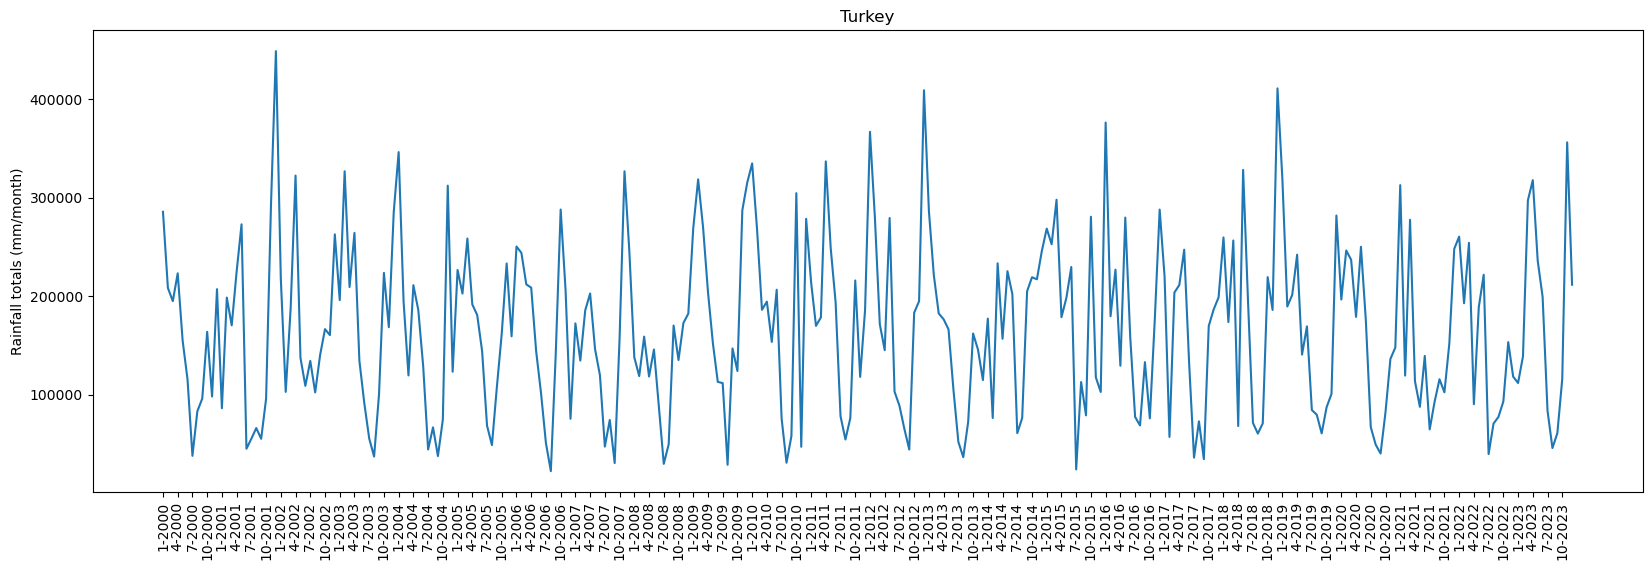

In [85]:
t, dates, totals = rainfall.get_country_total((1,12), (2000,2023),'TUR', world)
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(t, totals)
ax.set_xticks(t[::3])
ax.set_xticklabels(dates[::3], rotation=90)
ax.set_ylabel('Rainfall totals (mm/month)')
ax.set_title('Turkey')
plt.show()

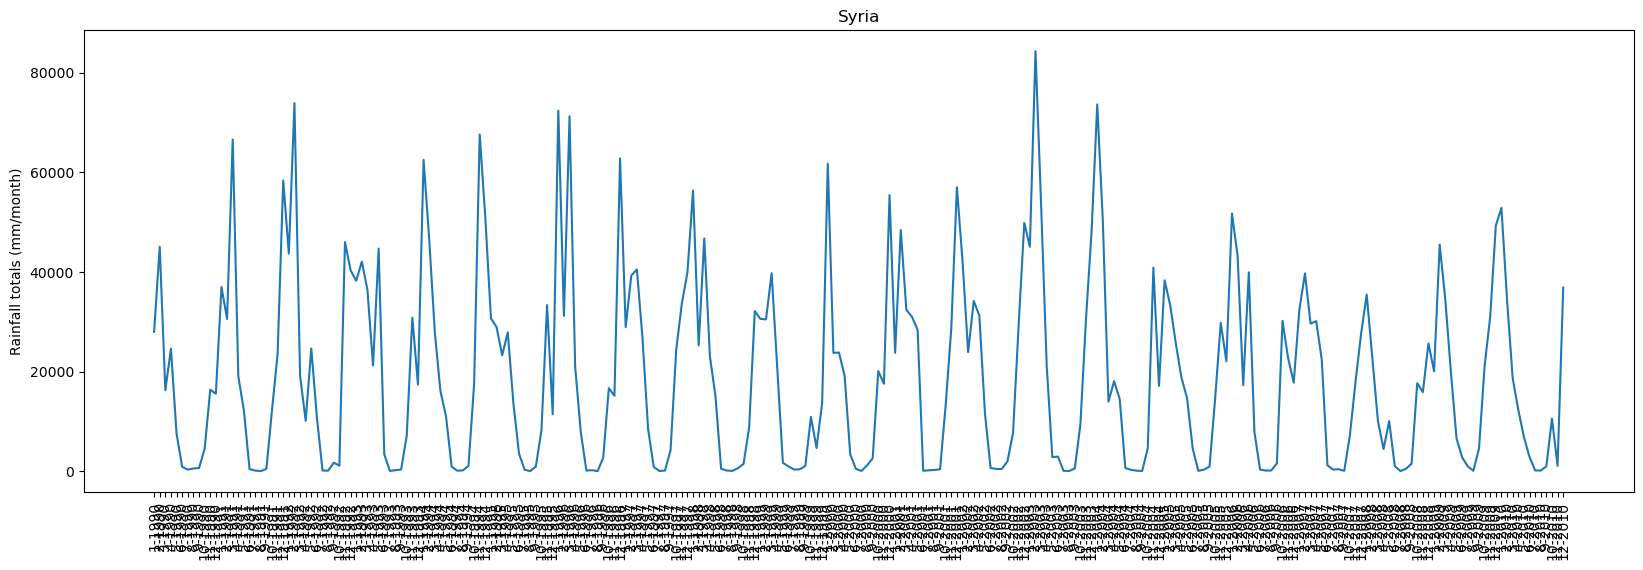

In [74]:
t, dates, totals = rainfall.get_country_total((1,12), (1990,2010),'SYR', world)
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(t, totals)
ax.set_xticks(t)
ax.set_xticklabels(dates, rotation=90)
ax.set_ylabel('Rainfall totals (mm/month)')
ax.set_title('Syria')
plt.show()

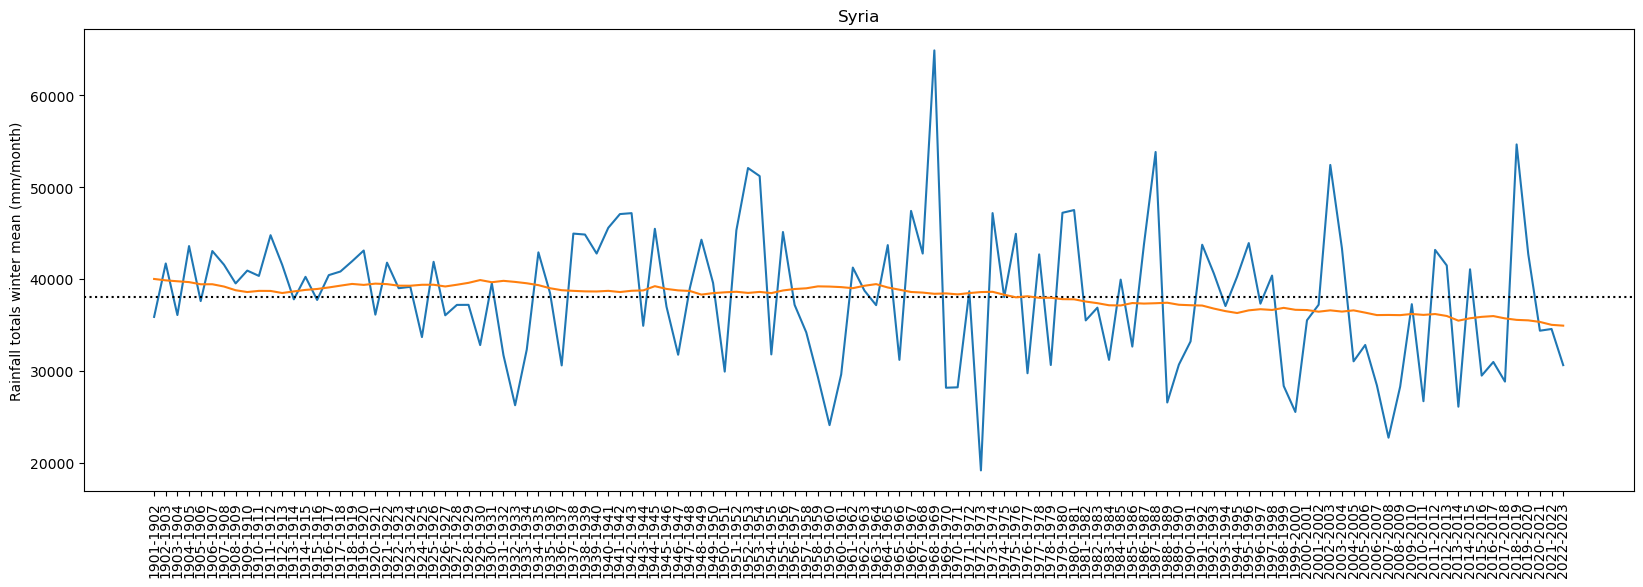

In [ ]:
t, dates, winter_means = rainfall.get_country_winter_mean((1901,2023), 'SYR', world)
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(t, winter_means)
ax.axhline(np.mean(winter_means), color='k', linestyle='dotted')
ax.plot(t, movmean(winter_means, window=50))
ax.set_xticks(t)
ax.set_xticklabels(dates, rotation=90)
ax.set_ylabel('Rainfall totals winter mean (mm/month)')
ax.set_title('Syria')
plt.show()

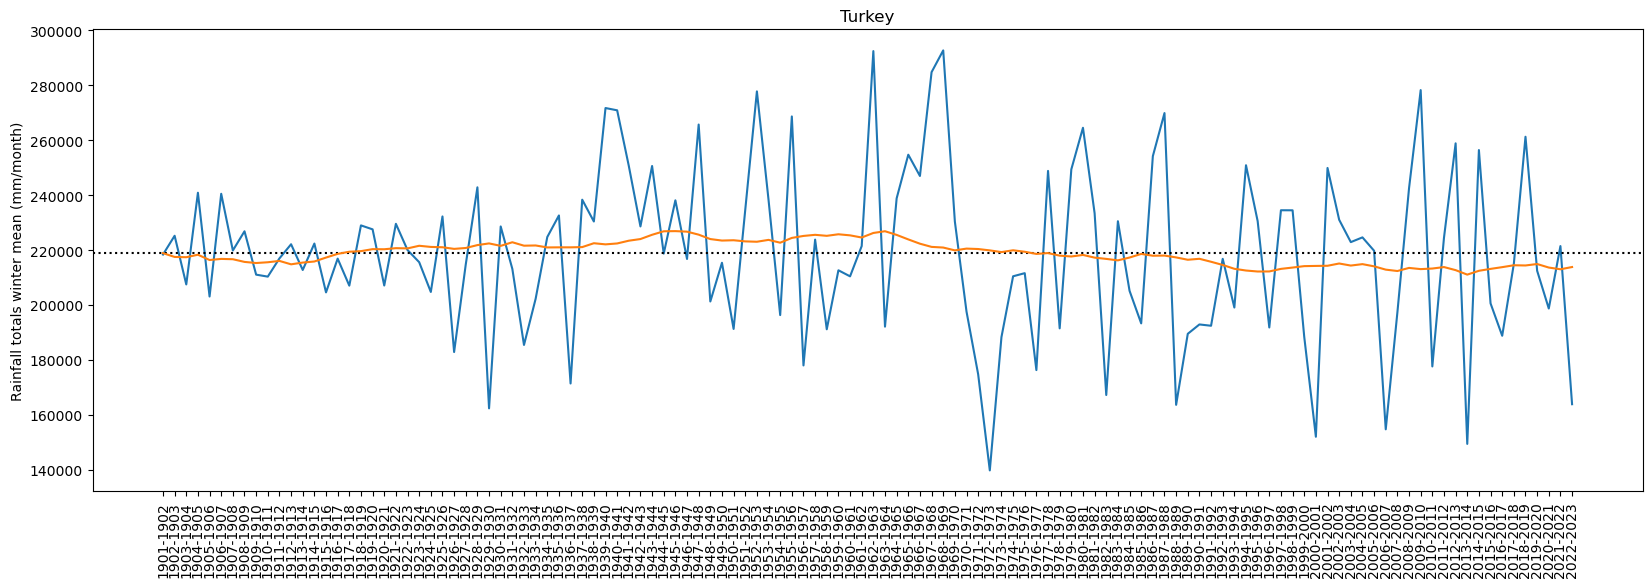

In [82]:
t, dates, winter_means = rainfall.get_country_winter_mean((1901,2023), 'TUR', world)
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(t, winter_means)
ax.axhline(np.mean(winter_means), color='k', linestyle='dotted')
ax.plot(t, movmean(winter_means, window=50))
ax.set_xticks(t)
ax.set_xticklabels(dates, rotation=90)
ax.set_ylabel('Rainfall totals winter mean (mm/month)')
ax.set_title('Turkey')
plt.show()